# Data Import and Preprocess

In [2]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import sys
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import cm, colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed
import keras
import seaborn as sns
import math
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from work_directory.other_examples.nn_backend.modified_loss_functions import step_msle, exp_msle, sigmoid_msle, cube_msle, linear_msle
from scipy.stats import norm, chisquare
import fast.s26_analysis.utils as utils 
from pathlib import Path

pc=0
#import personal scripts
if pc:
    sys.path.append(r"D:\personal_scripts")
else:
    sys.path.append(r"D:\personal_scripts")
from import_xyz_img import import_xyz_img
from conv_imgs import conv_imgs

#personalized colormap
viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:33, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

Scikit-optimize not installed. This is not essential since it is only used for the Hammersly scan pattern. We recommend using Halton, Sobol, or Latin hypercube instead.
Cannot find hdf5plugin and h5py packages. Cannot run the read_mda_h5_chunks_custom_roi function. Since this function has a very specific use case, this error can generally be ignored.


In [3]:
#Setup
pc=0


#Constants
pctg=5

curve_height_setpoint=20
curve_nsamples=12

cutout_size=9

#Graphics (1 to show images, 0 to not)
kernel_visualization=0 
input_imgs_view=0

#NN Setup
kernel_dim=3

iterations=300
batch_sz=200
lossf=cube_msle

#Other parameters
name='efm9'
topography_path=rf'd:\rawData\Datos_Small_R_Mauricio\Datos_Small_R_Mauricio\EFM9\EFM9 Topography Flattened_nm.txt'
ref_path=rf'd:\rawData\Datos_Small_R_Mauricio\Datos_Small_R_Mauricio\EFM9\Full_Cell_ep_Map_vFinal.txt'
#If using pre-processed curves introduce the path. For raw files set value to 0
curves_file=rf'd:\NN_Ep\pre_processed_curves\efm9_curves_calibrated.npy'

raw_curves_folder=0

#Parameters for curve import
calibrate_curves=1
curves_max_limit=1000
img_flip=0 #Used typically with EFM7

m_thresh=0.5
X=pd.read_csv(rf'd:\NN_Ep\no_norm_EMF9_data.csv')
X=X.iloc[:,1:]
print(X.columns)

Index(['Topography', 'Z = 21 nm', 'Z = 22 nm', 'Z = 23 nm', 'Z = 26 nm',
       'Z = 32 nm', 'Z = 42 nm', 'Z = 61 nm', 'Z = 97 nm', 'Z = 163 nm',
       'Z = 286 nm', 'Z = 515 nm', 'Z = 941 nm'],
      dtype='object')


In [4]:
#Curve import
if not raw_curves_folder:
    curves_projected=pd.DataFrame(np.load(rf'{curves_file}'))
else:
    m_vec=[]
    zetas=np.arange(curves_max_limit)
    curves_nu=np.zeros((1,curves_max_limit))
    num=0
    last=0

    onlyfiles = [f for f in listdir(curves_file) if isfile(join(curves_file, f))]

    for i in tqdm(onlyfiles, 
                    desc="Loading curves…", 
                    ascii=False, ncols=75):
        file = np.loadtxt(rf'{curves_file}\{i}', skiprows=72)

        file[:,0] = file[:,0]*1e9

        file=np.flip(file,axis=0)

        for n in np.arange(len(file))+1:
            if file[-n,0]<file[-n-1,0]:
                file=file[-n:,:]
                break

        m=(file[10,1]-file[0,1])/(file[10,0]-file[0,0])
        m_vec=np.append(m_vec,m)
        b=file[0,1]-(m*file[0,0])
        slope=m*file[:,0]+b

        baseline=np.mean(file[np.round(0.7*len(file)).astype(int):,1])
        base_std=np.std(file[np.round(0.7*len(file)).astype(int):,1])
        base_thresh=baseline-2*base_std

        for k in np.arange(0,len(file)):        
            if base_thresh>slope[(k)]:
                ZContact=file[(k),0]
                break


        file[:,0]=file[:,0]-ZContact


        maxx=np.argmax(file[:,2])
        file=file[maxx:,:]

        file[:,0]=np.round(file[:,0])
        file=pd.DataFrame(file)
        file.drop_duplicates(subset=0,inplace=True)
        file=np.array(file)
        ccc=file[:,2]
        zzz=file[:,0]
        projection = np.full((len(zetas)), np.nan)
        indices = np.where(np.isin(zetas, zzz.astype(int)))[0]
        cs=ccc[np.isin(np.round(zzz), zetas)]
        projection[indices] = ccc[np.isin(np.round(zzz), zetas)]
        projection=np.expand_dims(projection, axis=0)
        curves_nu=np.concatenate((curves_nu, projection), axis=0)

    curves_nu=curves_nu[1:,:]
    curves_nu=pd.DataFrame(curves_nu)
    curves_nu=curves_nu.interpolate(axis=1)
    curves_nu=curves_nu.bfill(axis=1)
    curves_projected=curves_nu

    if calibrate_curves:
        mean_m=abs(np.mean(m_vec))
        std_m=np.std(m_vec)

        #EFM9, EFM8, EFM7, EFM4: K=0.718, G=200, uac=3
        #EFVM: K=1.45 (mean between 1.2 and 1.7), G=100, uac=4
        K=0.718
        G=200
        uac=3
        A=(2** 0.5)*uac

        curves_projected=((4*K*(2**0.5))/(A**2))*((curves_projected)/(mean_m*G))



In [5]:
save_curves=0
if save_curves:
    np.save(rf'd:\NN_Ep\pre_processed_curves\{name}_curves_calibrated.npy', curves_projected)

In [6]:
'''file = np.loadtxt(rf'{curves_file}\{onlyfiles[2900]}', skiprows=72)

            
file[:,0] = file[:,0]*1e9

file=np.flip(file,axis=0)

for n in np.arange(len(file))+1:
    if file[-n,0]<file[-n-1,0]:
        file=file[-n:,:]
        break


m=(file[10,1]-file[0,1])/(file[10,0]-file[0,0])
m_mat=np.append(m_mat,m)
b=file[0,1]-(m*file[0,0])
slope=m*file[:,0]+b

baseline=np.mean(file[np.round(0.7*len(file)).astype(int):,1])
base_std=np.std(file[np.round(0.7*len(file)).astype(int):,1])
base_thresh=baseline-2*base_std
plt.plot(file[:,0], file[:,1])
plt.plot(file[:,0], slope)
plt.ylim([-1.7,-1.2])'''

"file = np.loadtxt(rf'{curves_file}\\{onlyfiles[2900]}', skiprows=72)\n\n            \nfile[:,0] = file[:,0]*1e9\n\nfile=np.flip(file,axis=0)\n\nfor n in np.arange(len(file))+1:\n    if file[-n,0]<file[-n-1,0]:\n        file=file[-n:,:]\n        break\n\n\nm=(file[10,1]-file[0,1])/(file[10,0]-file[0,0])\nm_mat=np.append(m_mat,m)\nb=file[0,1]-(m*file[0,0])\nslope=m*file[:,0]+b\n\nbaseline=np.mean(file[np.round(0.7*len(file)).astype(int):,1])\nbase_std=np.std(file[np.round(0.7*len(file)).astype(int):,1])\nbase_thresh=baseline-2*base_std\nplt.plot(file[:,0], file[:,1])\nplt.plot(file[:,0], slope)\nplt.ylim([-1.7,-1.2])"

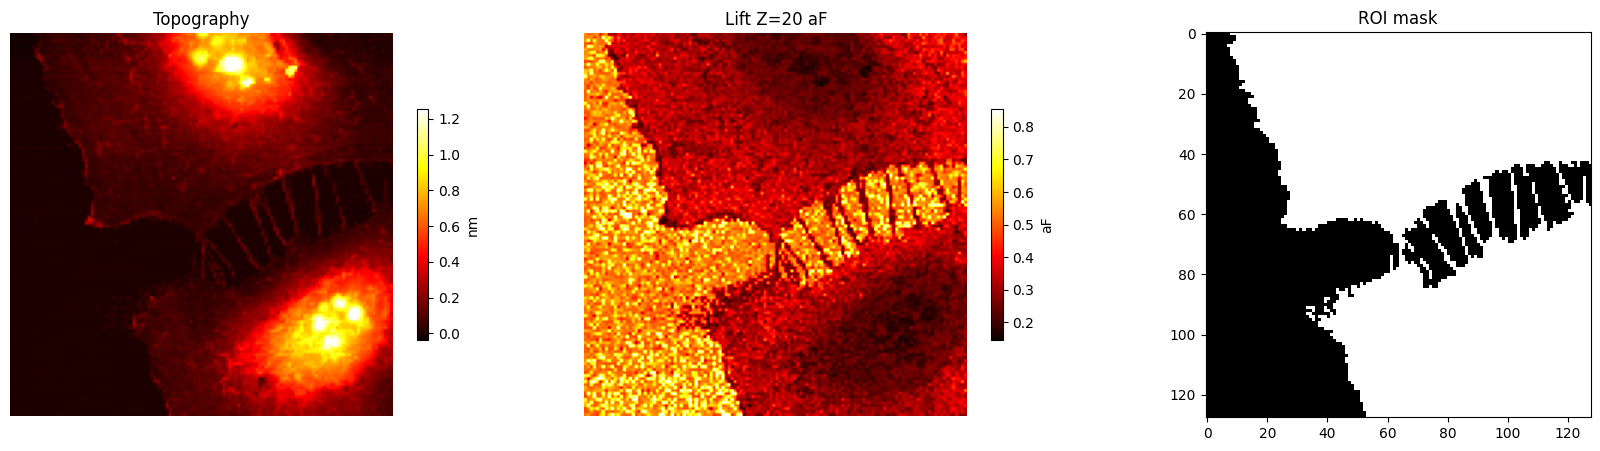

In [7]:
#Import Topography

file, x, y2 = import_xyz_img(rf'{topography_path}')
#file=np.loadtxt(rf'{topography_path}', skiprows=5)
file=np.expand_dims(file, axis=2)
if img_flip:
    file=np.flipud(file)
T_mat=copy(file)
og_dim=len(T_mat)
T=T_mat.reshape(og_dim**2,1)



mean_topo=np.mean(X.iloc[:,0])
std_topo=np.std(X.iloc[:,0])
Tn=copy(T)
Tn=(Tn-mean_topo)/std_topo


scale=StandardScaler()
Tn=scale.fit_transform(T)#????????????????????????????????

Tn_mat=Tn.reshape(og_dim,og_dim,1)

fig=plt.figure(figsize=(21,5))
ax=fig.add_subplot(1,3,1)
pcm=ax.imshow(T_mat, cmap='hot')
ax.set_title('Topography')
plt.colorbar(pcm, label='nm', shrink=0.6)
ax.axis('off')

ax=fig.add_subplot(1,3,2)
lift_z=20
lift=np.array(curves_projected.iloc[:,lift_z])
pcm=ax.imshow(lift.reshape(og_dim,og_dim), cmap='hot')
ax.set_title(rf'Lift Z={lift_z} aF')
plt.colorbar(pcm, label='aF', shrink=0.6)
ax.axis('off')

#Creation of a cutout mask to isolate our ROI. Parameters are tuneable depending on the image
#Typical values:
#EFM9: binary_threshold=0.01, object_size=3, hole_size=30
#EFM8: binary_threshold=0.41, object_size=3, hole_size=30
#EFM7: binary_threshold=0.095, object_size=4, hole_size=15
#EFVM: binary_threshold=0.05, object_size=2, hole_size=2
binary_threshold=0.01
object_size=3
hole_size=30

bin=copy(T)
bin_thresh=np.max(T_mat)*binary_threshold
bin[bin<=bin_thresh]=0
bin[bin>0]=1
bin=bin.astype(bool)
bin=bin.reshape(og_dim,og_dim)

from skimage import morphology

mask=copy(bin)
mask = morphology.remove_small_objects(bin, object_size)
mask = morphology.remove_small_holes(mask, hole_size)
ax=fig.add_subplot(1,3,3)
ax.imshow(mask, cmap='gray')
ax.set_title('ROI mask')



#Curve callibration

Factor_multip=1#0.067
curves_calibrated=curves_projected*Factor_multip


(-0.5, 8.5, 8.5, -0.5)

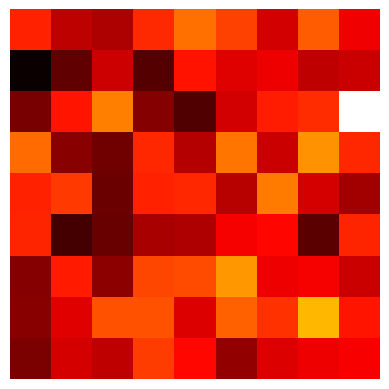

In [8]:
#Convolution cutouts
Tn_conv=conv_imgs(Tn_mat[:,:,0], cutout_size)
Tn_conv=np.expand_dims(Tn_conv, axis=-1)

plt.imshow(Tn_conv[int(len(Tn_conv)/2),:,:,:], cmap='hot')
plt.axis('off')

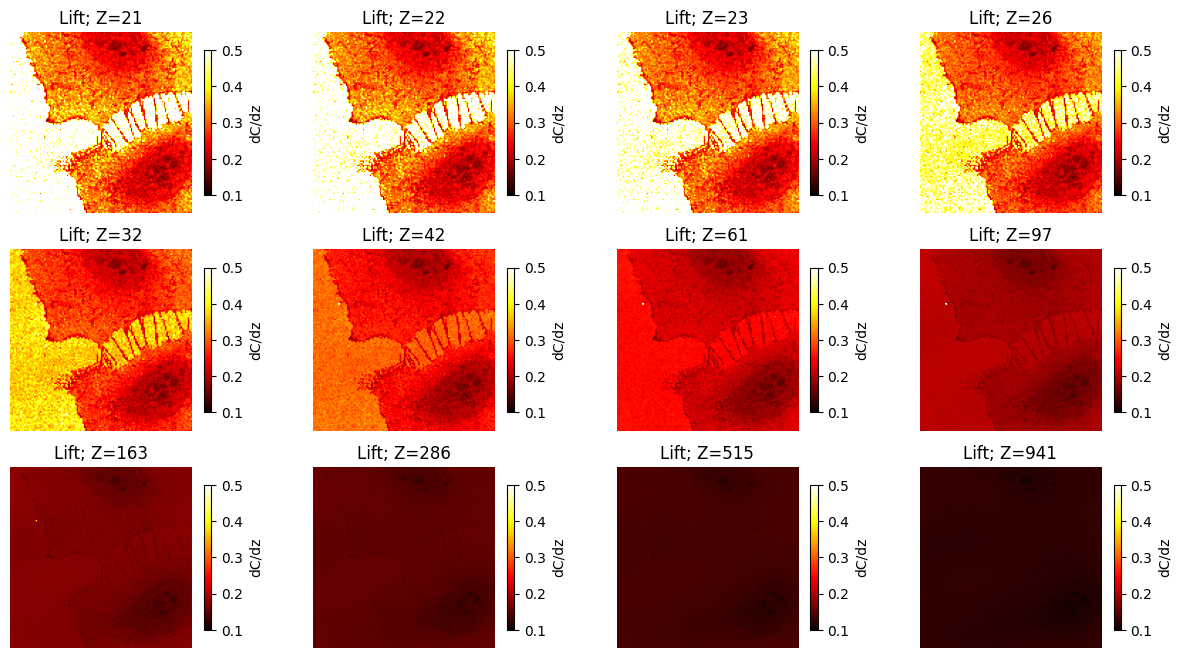

In [9]:
#Logarithmic sampling
maxlen=1713
zs=np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint
zs=np.round(zs)
zs=zs.astype(int)
samples = []
[samples.append(x) for x in zs if x not in samples]
samples=np.array(samples)

#samples=pd.DataFrame(copy(samples))

if np.any(samples>curves_max_limit):
    last_sample=samples[samples<=curves_max_limit]
    last_sample=last_sample[-1]
    samples[samples>curves_max_limit]=last_sample

nu_samples=curves_calibrated.iloc[:,samples]
nu_samples_mat=np.reshape(nu_samples,(128,128,curve_nsamples))
nu_samples=nu_samples_mat.reshape(128**2,curve_nsamples)

fig=plt.figure(figsize=(15,8))

for i in np.arange(len(nu_samples[0,:])):
    ax=fig.add_subplot(3,4,i+1)
    pcm=ax.imshow(nu_samples_mat[:,:,i], cmap='hot', vmin=0.1, vmax=0.5)
    plt.colorbar(pcm, label='dC/dz', shrink=0.8)
    ax.set_title(rf'Lift; Z={samples[i]}')
    ax.axis('off')
    

In [10]:
#Putting together data sets

#118 for EFM9, 120 rest
nu_dim=118


XNU=np.concatenate((T,nu_samples), axis=1)
n_features=len(XNU[0,:])
XNU_mat=XNU.reshape(og_dim,og_dim,n_features)

#Recortar XNU
side=int(og_dim/2)
dim_2=int(nu_dim/2)
XNU_mat=XNU_mat[side-dim_2:side+dim_2,side-dim_2:side+dim_2,:]
XNU=XNU_mat.reshape(nu_dim**2,n_features)




#Cell mask
cell=mask[side-dim_2:side+dim_2,side-dim_2:side+dim_2]
cell=cell.reshape(nu_dim**2,1)
cell_index=pd.DataFrame(copy(cell))
cell_index=cell_index.index[(cell_index[0])]

X_cell=X.iloc[cell_index,:]

XNUn=copy(XNU)
for i in np.arange(len(X_cell.iloc[0,:])):
    mean_feat=np.mean(X_cell.iloc[:,i])
    std_feat=np.std(X_cell.iloc[:,i])
    XNUn[:,i]=(XNUn[:,i]-mean_feat)/std_feat

XNUn=pd.DataFrame(XNUn)


scale=StandardScaler()
#XNUn=pd.DataFrame(scale.fit_transform(XNU))


XNUn_cell=XNUn.iloc[cell_index,:]
Tn_conv_cell=Tn_conv[cell_index,:]

print(rf'''
    Sample summary
    ------------------------
    Image dimensions = {nu_dim} x {nu_dim} px
    ROI data = {len(cell_index)} px
'''
)


    Sample summary
    ------------------------
    Image dimensions = 118 x 118 px
    ROI data = 9372 px



### Train Data

C:\Users\mcano\AppData\Local\Temp\ipykernel_22140\275613362.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  qqq=float(mask_ep.quantile(m_ep_thresh))


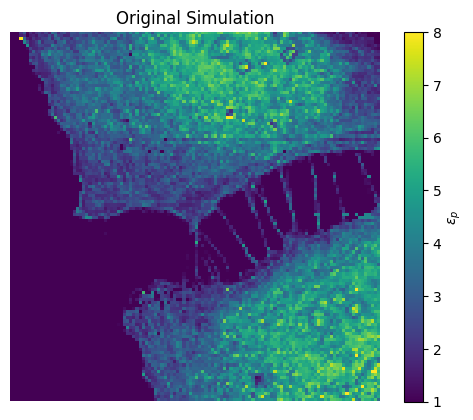

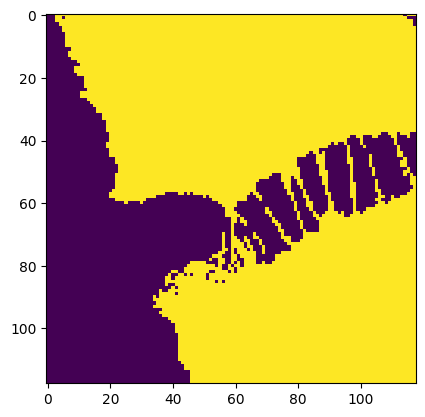

In [11]:
ref_img, x, y2 = import_xyz_img(rf'{ref_path}')

# For EFM9
side=int(118/2)
ref_img=np.flipud(ref_img)

# For EFVM
#side=int(120/2)

ref_img=np.flipud(ref_img)
ref_img=ref_img[side-dim_2:side+dim_2,side-dim_2:side+dim_2]
small_nu=np.reshape(ref_img,((dim_2*2)**2))

#EFM8 m_thresh=0.77
#EFM7 m_thresh=0.44
#EFM9 m_thesh=0.20
#EVFM m_thesh=0.785
m_ep_thresh=0.20

mask_ep=pd.DataFrame(copy(small_nu))
qqq=float(mask_ep.quantile(m_ep_thresh))
mask_ep[(mask_ep[0]<qqq)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((dim_2*2),(dim_2*2)))

mask_ep_indexes=mask_ep.index[mask_ep[0]>0].tolist()

plt.imshow(ref_img, vmin=1, vmax=8)
plt.colorbar(label="$ε_p$")
plt.axis('off')
plt.title('Original Simulation')

plt.figure()
plt.imshow(mask_ep_im)

In [12]:
ynu=pd.DataFrame(small_nu)
ynu_cell=pd.DataFrame(small_nu[mask_ep_indexes])
XNUn_cell_2=XNUn.iloc[mask_ep_indexes,:]
Tn_conv_cell_2=Tn_conv[mask_ep_indexes,:]



Tn_conv_rot90=np.rot90(Tn_conv,k=1,axes=(1,2))
Tn_conv_rot180=np.rot90(Tn_conv,k=2,axes=(1,2))
Tn_conv_rot270=np.rot90(Tn_conv,k=3,axes=(1,2))

Tn_conv_ud=np.flip(Tn_conv,axis=1)
Tn_conv_lr=np.flip(Tn_conv,axis=2)

'''
Tn_conv_rot90=np.rot90(Tn_conv_cell_2,k=1,axes=(1,2))
Tn_conv_rot180=np.rot90(Tn_conv_cell_2,k=2,axes=(1,2))
Tn_conv_rot270=np.rot90(Tn_conv_cell_2,k=3,axes=(1,2))

Tn_conv_ud=np.flip(Tn_conv_cell_2,axis=1)
Tn_conv_lr=np.flip(Tn_conv_cell_2,axis=2)'''

'\nTn_conv_rot90=np.rot90(Tn_conv_cell_2,k=1,axes=(1,2))\nTn_conv_rot180=np.rot90(Tn_conv_cell_2,k=2,axes=(1,2))\nTn_conv_rot270=np.rot90(Tn_conv_cell_2,k=3,axes=(1,2))\n\nTn_conv_ud=np.flip(Tn_conv_cell_2,axis=1)\nTn_conv_lr=np.flip(Tn_conv_cell_2,axis=2)'

In [13]:
pctg_partial=0.5
sss_ep = ShuffleSplit(n_splits=1, test_size=1-(pctg_partial/100), random_state=1)
sss_ep.get_n_splits(XNUn_cell_2, ynu_cell)
train_index, test_index = next(sss_ep.split(XNUn_cell_2, ynu_cell))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



XNU_train, XNU_test = XNUn_cell_2.iloc[train_index], XNUn_cell_2.iloc[test_index] 
ynu_train, ynu_test = ynu_cell.iloc[train_index], ynu_cell.iloc[test_index]

Tn_conv_train, Tn_conv_test = Tn_conv_cell_2[train_index,:,:], Tn_conv_cell_2[test_index,:,:] 

Tn_conv_rot90_train =Tn_conv_rot90[train_index,:,:]
Tn_conv_rot180_train =Tn_conv_rot180[train_index,:,:]
Tn_conv_rot270_train =Tn_conv_rot270[train_index,:,:]
Tn_conv_ud_train =Tn_conv_ud[train_index,:,:]
Tn_conv_lr_train=Tn_conv_lr[train_index,:,:]

Tn_conv_train_aug=copy(Tn_conv_train)
Tn_conv_train_aug=np.concatenate((Tn_conv_train_aug, Tn_conv_rot90_train,Tn_conv_rot180_train,Tn_conv_rot270_train,Tn_conv_ud_train, Tn_conv_lr_train), axis=0)


N_aug=int(len(Tn_conv_train_aug[:,0,0,0])/len(Tn_conv_train[:,0,0,0]))

XNU_train_aug=copy(XNU_train)
ynu_train_aug=copy(ynu_train)
for i in np.arange(N_aug-1):
    XNU_train_aug=pd.DataFrame(np.concatenate((XNU_train_aug, XNU_train), axis=0))
    ynu_train_aug=pd.DataFrame(np.concatenate((ynu_train_aug, ynu_train), axis=0))

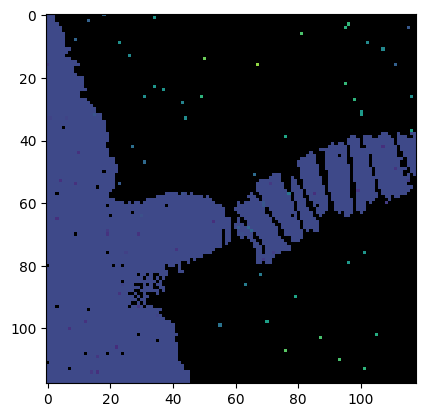

In [14]:
recon_nometal_index=(XNU_train.index)

no_cell=np.arange(nu_dim**2)
substrate=[]
[substrate.append(x) for x in no_cell if x not in cell_index]
recon_index=np.append(recon_nometal_index, substrate)


train_img=np.zeros(nu_dim**2)
train_img[recon_index]=small_nu[recon_index]
train_img=train_img.reshape(nu_dim,nu_dim)
plt.imshow(train_img, vmin=-1, vmax=8, cmap=newcmp)

18
18 18


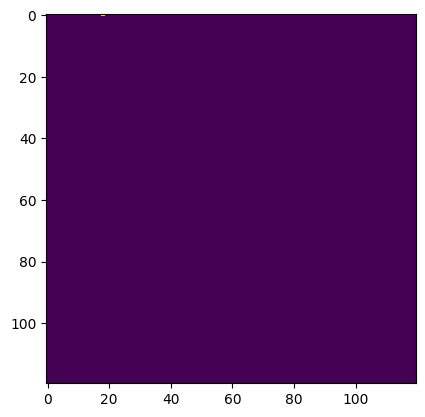

In [15]:
y_coord, x_coord= np.unravel_index(recon_index, (nu_dim, nu_dim))
init_pattern=np.column_stack((y_coord, x_coord))

test=np.zeros((120**2))
test[recon_index[0]]=1
test=test.reshape(120,120)
plt.figure()
plt.imshow(test)
test[y_coord[0],x_coord[0]]=2
plt.imshow(test)
print(x_coord[0])

new_vec = np.ravel_multi_index((y_coord,x_coord),(nu_dim,nu_dim))

print(recon_index[0],new_vec[0])

In [16]:

erd_model_to_load = Path.cwd().parent / 'training/cameraman/c_2/erd_model_relu.pkl'
sample_fast = utils.create_experiment_sample(numx=ref_img.shape[1], numy=ref_img.shape[0],
                                        inner_batch_size=50,
                                        initial_idxs=init_pattern,
                                        erd_model_file_path=erd_model_to_load)

In [17]:
#Establish network architecture
def nn_for_ep(xtrain,convtrain,ytrain,xtest,convtest,ytest, lossf=cube_msle, verb=1):
    set_random_seed(1)
    inp_x=Input(shape=(len(xtrain.columns),))
    inp_cv=Input(shape=(np.shape(convtrain[0])))


    cv=Conv2D(filters=32, kernel_size=(kernel_dim, kernel_dim), activation='relu')(inp_cv)
    cv=Flatten()(cv)
    cv=Dense(256,activation ="relu")(cv)
    cv=Model(inputs=inp_cv, outputs=cv)

    x=Dense(256, activation='relu')(inp_x)
    x=Model(inputs=inp_x, outputs=x)

    mix=concatenate([x.output,cv.output])

    mix=Dense(256, activation='relu')(mix)
    mix=Dense(128, activation='relu')(mix)
    mix=Dense(64, activation='relu')(mix)
    mix=Dense(32, activation='relu')(mix)
    out=Dense(1)(mix)

    reg = Model(inputs=[x.input, cv.input], outputs=out)
    reg.compile(loss=lossf,optimizer=Adam(),metrics=['mae'])
    histo=reg.fit([xtrain,convtrain], ytrain, batch_size=batch_sz, epochs=iterations, validation_data=[[xtest,convtest],ytest], verbose=verb)
    return reg, histo

def train_curve(folder,filename,histo):
    
    train=histo.history['mae']
    test=histo.history['val_mae']
    plt.plot(train)
    plt.plot(test)
    plt.legend(['train','test'])
    plt.grid('on')
    
    train, test = [str(element) for element in train], [str(element) for element in test]
    h_train, h_test=["train"], ["test"]
    h_train+=train
    h_test+=test
    export=np.column_stack((h_train,h_test))

    np.savetxt(rf'{folder}\{filename}_traincurve.txt',export,fmt='%s',delimiter=',')

def img_export(filename, folder, matrix, vector):
    Original_file=copy(topography_path)
    Image_to_export=matrix
    ########
    template=np.loadtxt(rf'{Original_file}', skiprows=4)
    template=np.reshape(template, (len(T_mat),len(T_mat),3))
    template=template[side-dim_2:side+dim_2,side-dim_2:side+dim_2,:]
    template=template.reshape((dim_2*2)**2,3)
    new_xyz=copy(template)
    flipped_img=np.flipud(Image_to_export)
    flipped_img=flipped_img.reshape(len(Image_to_export)**2)
    new_xyz[:,2]=flipped_img
    np.savetxt('temp_xyz_data.txt',new_xyz, delimiter='\t')


    header='WSxM file copyright UAM\nWSxM ASCII XYZ file\nX[nm]\tY[nm]\tZ[ep]\n'
    with open('temp_xyz_data.txt') as fp:
        data = fp.read()

    full_export=copy(header)
    full_export+='\n'
    full_export+=data

    with open (rf'{folder}\{filename}.txt', 'w') as fp:
        fp.write(full_export)

    np.savetxt(rf'{folder}\{filename}_vec.csv',vector)   

In [18]:
from copy import deepcopy

import numpy as np
import numpy.typing as npt

from fast.input_params import ERDInputParams, GeneralInputParams, SampleParams
from fast.utils.img_loader import renormalize
from fast.core.data_structures import MeasurementInfo, NeighborsInfo
from fast.core.erd import ERDModel
from fast.core.measurement_interface import MeasurementInterface
from fast.core.neighbors import find_neighbors
from fast.core.recons import compute_recon
from fast.core.slads_features import compute_poly_features

In [19]:
reg, histo=nn_for_ep(XNU_train_aug,Tn_conv_train_aug,ynu_train_aug,XNU_test,Tn_conv_test,ynu_test, verb=0)


In [20]:
# Actual simulation run. This can be fairly time consuming
masks_all = []
train_masks_all=[]
train_ratios_all=[]
recons_fast_all = []
ratios_all = []
tot_erds_all = []
count = 0
new_idxs = copy(init_pattern)

train_mask=np.zeros(nu_dim**2)
for i in recon_nometal_index:
    train_mask[i]=1
train_mask_still=copy(train_mask).reshape(nu_dim,nu_dim)
train_masks_all.append(train_mask_still)
train_ratio=train_mask_still.sum()/len(mask_ep_indexes)
train_ratios_all.append(train_ratio.copy())



n_scan_points = int(0.05 * len(mask_ep_indexes))
pbar = tqdm(total=n_scan_points, desc='Scanned points')
print(pbar.n)
# Continue until we measure 40% of the points.
while train_mask_still.sum() < n_scan_points:
    # Supply the measurement values.
    sample_fast.measurement_interface.finalize_external_measurement(ref_img[new_idxs[:,0], new_idxs[:,1]])
    
    # Supply in measurement positions
    sample_fast.perform_measurements(new_idxs)
    




    
    # Use the measurement values to reconstruct the sample and calculate the ERDs
    #sample_fast.reconstruct_and_compute_erddd(mmm=1) ###Modify in fast\core\recons

        # Compute feature information for SLADS models; not needed for DLADS
    unmeasured_idxs = sample_fast._get_limited_update_locations(sample_fast.mask.copy(), deepcopy(sample_fast.measurement_info))

    measurement_info = deepcopy(sample_fast.measurement_info)
    measurement_info.unmeasured_idxs = unmeasured_idxs

    # Determine neighbor information for all unmeasured locations
    if len(sample_fast.measurement_info.unmeasured_idxs) > 0:
        sample_fast.neighbors = find_neighbors(measurement_info, sample_fast.params_gen.num_neighbors)
    else:
        sample_fast.neighbors = NeighborsInfo([], [], [], [])

    # Compute reconstructions, resize to physical dimensions
    res=reg.predict([XNUn_cell, Tn_conv_cell])
    #VISUALIZACIÓN DE DATOS CALCULADOS
    res_vec=np.zeros(nu_dim**2)+1
    for i in np.arange(len(cell_index)):
        res_vec[cell_index[i]]=res[i,0]
    res_img=res_vec.reshape(nu_dim,nu_dim)
        
    sample_fast.recon_image = copy(res_img)
    

    if sample_fast.params_erd.model_type == "slads-net":
        sample_fast.poly_features = compute_poly_features(
            sample_fast.params_sample,
            sample_fast.recon_image,
            unmeasured_idxs,
            sample_fast.neighbors,
            sample_fast.params_erd.feat_distance_cutoff,
            sample_fast.params_erd.feature_type,
        )

    # Compute RD/ERD; if every location has been scanned all positions are zero
    # Determine the Estimated Reduction in Distortion

    if len(measurement_info.unmeasured_idxs) == 0:
        sample_fast.RD = np.zeros(sample_fast.params_sample.image_shape)
        sample_fast.ERD = np.zeros(sample_fast.params_sample.image_shape)
    else:
    # Compute the ERD with the prescribed model
        if sample_fast.params_erd.model_type == "slads-net":
            erds = sample_fast.erd_model.predict(sample_fast.poly_features)

        sample_fast.ERD[unmeasured_idxs[:, 0], unmeasured_idxs[:, 1]] = erds
        sample_fast.ERD = sample_fast._rescale_and_fix_erd(sample_fast.ERD, sample_fast.mask)
        sample_fast.iteration += 1





    # Compute new positions.

    new_idxs = sample_fast.find_new_measurement_idxs()
    
    
    new_idxs_vec = np.ravel_multi_index((new_idxs[:,0],new_idxs[:,1]),(nu_dim,nu_dim))
    
    new_idxs_vec_cell = []
    [new_idxs_vec_cell.append(x) for x in new_idxs_vec if x in mask_ep_indexes] 
    
    y_coord, x_coord= np.unravel_index(np.array(new_idxs_vec_cell).astype(int), (nu_dim, nu_dim))
    provisional_idxs=np.column_stack((y_coord, x_coord))
    
    if len(provisional_idxs)>0:
        XNUn_new=XNUn.iloc[new_idxs_vec_cell,:]
        Tn_conv_new=Tn_conv[new_idxs_vec_cell,:]
        ynu_new=pd.DataFrame(small_nu[new_idxs_vec_cell])
        reg.fit([XNUn_new,Tn_conv_new],ynu_new, verbose=0)
        new_idxs=copy(provisional_idxs)
        print(rf"n train pixels = {len(new_idxs)}")
        for i in new_idxs_vec_cell:
            train_mask[i]=1
        train_mask_still=copy(train_mask).reshape(nu_dim,nu_dim)
    else:
        new_idxs=new_idxs[:10]
    train_ratio=train_mask_still.sum()/len(mask_ep_indexes)
    train_ratios_all.append(train_ratio.copy())
    ratio = sample_fast.ratio_measured
    ratios_all.append(ratio)
    tot_erds_all.append(sample_fast.ERD.sum())
    recons_fast_all.append(sample_fast.recon_image.copy())
    masks_all.append(sample_fast.mask.copy())
    train_masks_all.append(train_mask_still.copy())
    pbar.update(int(train_mask_still.sum() - pbar.n))
res=reg.predict([XNUn_cell, Tn_conv_cell])
#VISUALIZACIÓN DE DATOS CALCULADOS
res_vec=np.zeros(nu_dim**2)+1
for i in np.arange(len(cell_index)):
    res_vec[cell_index[i]]=res[i,0]
res_img=res_vec.reshape(nu_dim,nu_dim)
recons_fast_all.append(res_img.copy())

Scanned points:   0%|          | 0/461 [00:00<?, ?it/s]

0
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  21%|██        | 96/461 [00:01<00:03, 93.20it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  32%|███▏      | 146/461 [00:01<00:04, 72.96it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  43%|████▎     | 196/461 [00:02<00:04, 62.44it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  53%|█████▎    | 246/461 [00:03<00:03, 58.43it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  64%|██████▍   | 296/461 [00:04<00:02, 56.29it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  75%|███████▌  | 346/461 [00:05<00:02, 53.77it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  86%|████████▌ | 396/461 [00:06<00:01, 54.32it/s]

n train pixels = 50
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points:  96%|█████████▌| 443/461 [00:07<00:00, 52.92it/s]

n train pixels = 47
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Scanned points: 489it [00:08, 51.15it/s]                         

n train pixels = 46
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


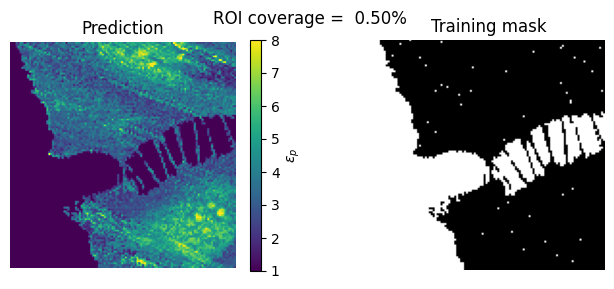

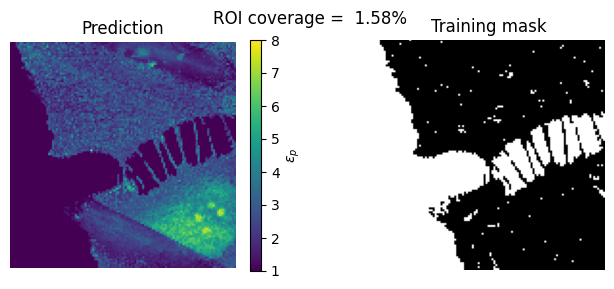

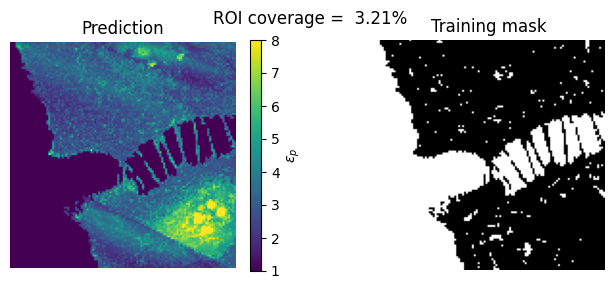

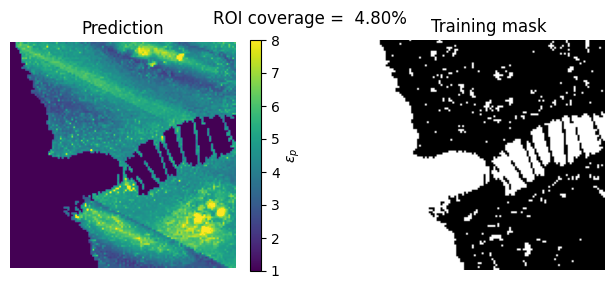

In [21]:
for ix in np.array(np.linspace(0, len(ratios_all)-1, 4)).astype(int):
    plt.figure(figsize=[8, 3])
    plt.subplot(1,2,1)
    plt.imshow(recons_fast_all[ix], vmin=1, vmax=8)
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(label="$ε_p$")
    plt.subplot(1,2,2)
    plt.imshow(masks_all[ix], cmap='gray')
    plt.axis('off')
    plt.title('Training mask')
    plt.suptitle(f'ROI coverage = {train_ratios_all[ix] * 100: 3.2f}%')
    plt.show()

In [22]:
def histogram_export(input, filename, folder, start=0, stop=8, step=0.1):
    hist, bins= np.histogram(input, np.arange(start,stop,step))
    hist=np.column_stack((hist, bins[1:]))
    np.savetxt(rf'{folder}\{filename}_hist.csv', hist, delimiter=',')

Scanned points: 489it [00:20, 51.15it/s]

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


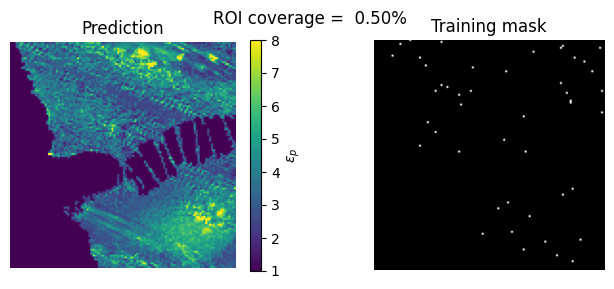

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


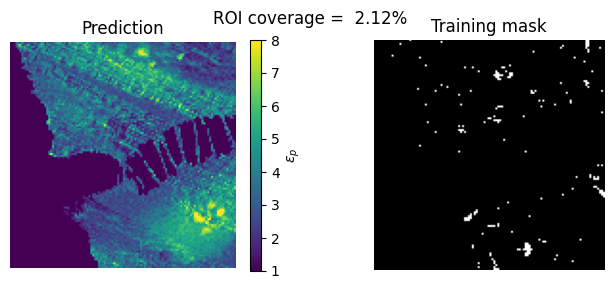

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


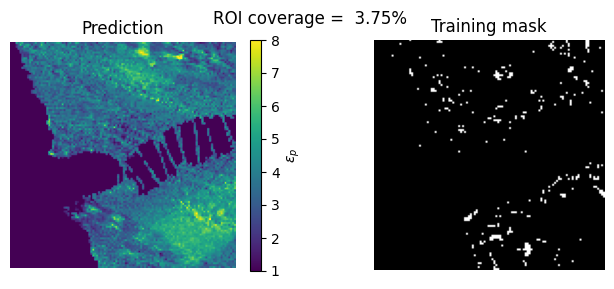

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


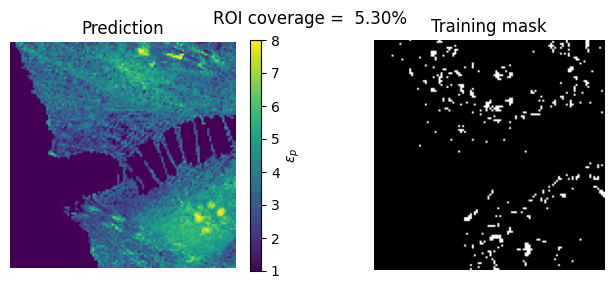

In [23]:
folder=rf'D:\FAST\fast_smart_scanning\pres_240510'


for ix in np.array(np.linspace(0, len(train_ratios_all)-1, 4)).astype(int):
    smart_mask=pd.DataFrame(train_masks_all[ix].reshape(nu_dim**2))
    smart_mask=smart_mask.index[smart_mask[0]>0].tolist()
    
    XNUn_smart=XNUn.iloc[smart_mask,:]
    Tn_conv_smart=Tn_conv[smart_mask,:]
    ynu_smart=pd.DataFrame(small_nu[smart_mask])

    reg_smart, histo=nn_for_ep(XNUn_smart,Tn_conv_smart,ynu_smart,XNU_test,Tn_conv_test,ynu_test, verb=0)
    res_smart=reg_smart.predict([XNUn_cell, Tn_conv_cell])
    #VISUALIZACIÓN DE DATOS CALCULADOS
    smart_recon_vec=np.zeros(nu_dim**2)+1
    for i in np.arange(len(cell_index)):
        smart_recon_vec[cell_index[i]]=res_smart[i,0]
    smart_recon_img=smart_recon_vec.reshape(nu_dim,nu_dim)

    filename=rf'{name}_{int(train_ratios_all[ix] * 10000)}_pct_smart_drive'
    img_export(filename, folder, smart_recon_img, smart_recon_vec[mask_ep_indexes])
    histogram_export(smart_recon_vec[mask_ep_indexes], filename, folder)

    plt.figure(figsize=[8, 3])
    plt.subplot(1,2,1)
    plt.imshow(smart_recon_img, vmin=1, vmax=8)
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(label="$ε_p$")
    plt.subplot(1,2,2)
    plt.imshow(train_masks_all[ix], cmap="gray")
    plt.axis('off')
    plt.title('Training mask')
    plt.suptitle(f'ROI coverage = {(train_ratios_all[ix] * 100): 3.2f}%')
    plt.show()



In [24]:
export_ref=0
filename=rf'{name}_sim'
folder=rf'D:\FAST\fast_smart_scanning\pres_240426'

if export_ref: 
    img_export(filename, folder, ref_img, ynu_cell)
    histogram_export(ynu_cell, filename, folder)

In [25]:
true=np.loadtxt(rf'D:\FAST\fast_smart_scanning\pres_240426\efvm_504_pct_smart_drive_vec.csv')
pred=np.loadtxt(rf'D:\FAST\fast_smart_scanning\pres_240426\efvm_sim_vec.csv')

print(len(true))
print(len(pred))

print(r2_score(true,pred))

3092
3092
0.70219138305773
